# Study of housing prices in Belgium, part 3: Regression analysis (OLS and Random Forests)

## Importing packages

In [1]:
# import packages

import pandas as pd
import numpy as np

# packages for prediction: OLS estimation
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
# packages for prediction: Random forest regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns


## Importing datasets

In [2]:
# notebook settings
pd.options.display.max_columns = None
path = "C:/Users/Bedoret/OneDrive/Data Science/Housing prices in Belgium/"

# immoweb dataset
properties = pd.read_excel('{}properties_2021_11_29.xlsx'.format(path), index_col = 0)
properties2 = properties

# additional datasets on population density, income level and urbanisation rate per municipality
refnis = pd.read_excel('{}INSEE-Belgique.xlsx'.format(path))
population = pd.read_excel('{}Population_2019.xlsx'.format(path), index_col = 0)
income = pd.read_excel('{}Revenus_2018.xlsx'.format(path), index_col = 0)
price_2020 = pd.read_excel('{}Prix_median_2020.xlsx'.format(path))


# postal codes of Brussel's ans Knokke municipalities
bxl = pd.DataFrame([1000,1020,1030,1040,1050,1060,1070,1080,1081,1082,1083,1090,1140,1150,1160,1170,1180,1190,1200,1210],
                    columns={"Code postal"})
bxl["Bxl"] = 1
knokke = pd.DataFrame([8300, 8301], columns= {"Code postal"})
knokke["Knokke"] = 1

In [3]:
# merge the additional datasets with our immoweb dataset 
properties = properties.merge(refnis, on = "Code postal", how = "left" )
properties = properties.astype({"Refnis": int})

properties = properties.merge(population, on = "Refnis", how = "left")\
                         .merge(income, on = "Refnis", how = "left")\
                         .merge(price_2020, on = "Refnis", how = "left")\
                         .merge(bxl, on = "Code postal", how = "left")\
                         .merge(knokke, on = "Code postal", how = "left")
properties = properties.astype({"Code postal": int})
properties["Bxl"].fillna(0, inplace=True)
properties["Knokke"].fillna(0, inplace=True)

# extract apartments and houses datasets from our main dataset
houses = properties.loc[properties["Type"]=="HOUSE"]
apartments = properties.loc[properties["Type"]=="APARTMENT"]

## Quality check of the datasets

In [4]:
# look at the percentage of missing values for each variable in each dataset.
# Missing values may have a strong impact on the results !
# In a classic linear regression, any observration with missing values will be removed from the analysis, 
# leaving only observations for which the features are non missing. We must then ensure that removing 
# observations with any missing values will not affect the price too much. In other words we must ensure 
# that our new sample remains representative of our original dataset when these observations are removed.

def percent_missing(df):
    percent_missing = pd.DataFrame(df.isnull().mean()*100)
    percent_missing.sort_values(0, inplace = True, ascending = False)
    return percent_missing

# percent_missing(properties).join(percent_missing(houses), lsuffix = '_properties', rsuffix = '_houses')\
#                            .join(percent_missing(apartments), rsuffix = '_apartments')


In [5]:
# How does the average price per square meter change when we remove the observations for which we observe missing values?.
# If the difference is large, it implies that missing values in that variable have an impact on the average price.
# Hence we might prefer to withdraw these variables from our analysis, as they might bias the overall price average.

def price_diff(df, var):
    """
    computes the average price per square meter of the total 
    data frame (df) versus the average price per square meter when 
    missing values of 'var' are removed.
    returns:
    'avg1': the average price the full dataset
    'avg2': the average price of the dataset without the observation whith missing values in var.
    """
    avg1 = int(df['Prix'].mean())
    avg2 = int(df[(var.notna())]['Prix'].mean())
    return  print("all data:     ",avg1,"\nna's removed: ", avg2,"\ndiff:         ", avg1-avg2)


# example: removing observations with missing values in "garden size" increases the average price per sq meter by 133€.
#price_diff(houses, houses["Surface du jardin"])

## Define the OLS and Random Forest functions

In [6]:
def load_data(df, algo, knokke_excl):
    ''' function that loads our datasets ready for the algorithms'''
    df.dropna(inplace = True)
    if knokke_excl == True:
        df = df.loc[df['Knokke'] == 0]
    if algo == "OLS":
        y_data = df["Prix"]
        x_data = df.loc[:, df.columns != "Prix"]
        feature_names = None
    elif algo == "RFR":
        y_data = df["Prix"].to_numpy('float').tolist()  
        x_data = df.loc[:, df.columns != 'Prix'].to_numpy('float').tolist()
        feature_names = list(df)[1:]
    else:
        print("No algorithm defined")
    return  x_data, y_data, feature_names 


def OLS_regression(x_data, y_data):
    ''' function that applies an OLS regression algorithm to our x_data and y_data'''
    x_data = sm.add_constant(x_data)
    OLS_model = sm.OLS(y_data, x_data).fit()
    y_pred = OLS_model.predict(x_data)
    return OLS_model, y_pred, r2_score(y_data, y_pred)


def forest_regression(x_data, y_data):
    '''
    function that splits data randomly into a training (85%) and a test (15%) set
    then apply the random forest regression to the training data (x_train, y_train)
    then predicts the labels (y_pred) of the test data (x_test) using the trained model
    and outputs the R-squred score of the trained model (correlation between predicted and true outcomes)
    '''
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.15)
    model_RFR = RandomForestRegressor(n_estimators=500, max_depth=None, random_state=0).fit(x_train, y_train)
    y_pred = model_RFR.predict(x_test)
    return y_test, y_pred, r2_score(y_test, y_pred), model_RFR

## Exploratory analysis / Data Visualisation

In [7]:
houses.head()

,Identifiant,Type,Étage,Code postal,Prix,Prix m2,Surface habitable,Surface du terrain,Chambres,Type de cuisine,Salles de bains,Ratio chambres sdb,Toilettes,Terrasse,Surface de la terrasse,Jardin,Surface du jardin,Nombre de façades,Parking,Année de construction,État du bâtiment,Type de chauffage,Classe énergétique,URL,Commune_x,Refnis,Langue,Commune ppale,Degré d'urbanisation,Pop densité (km2),Superficie (m2),Total population,Commune_y,Code postal (2),Population active,Revenu total,Revenu moyen,Prix median 2020 appartements,Prix median 2020 maisons,Bxl,Knokke
6,9633753,HOUSE,NaN,1000,990000,4008.097166,247,125.0,6.0,2.0,3.0,2.0,3.0,1,28.0,0,NaN,2.0,1,1956.0,4.0,NaN,9.0,https://www.immoweb.be/fr/annonce/9633753,Bruxelles,21004,FN,BRUXELLES,1.0,5573.404049,32605926.0,181726.0,Bruxelles,1000.0,110968.0,2.367726e+09,21337.012397,236000.0,363000.0,1.0,0.0
34,9402335,HOUSE,NaN,1000,1200000,2112.676056,568,196.0,3.0,2.0,3.0,1.0,5.0,0,NaN,0,NaN,2.0,0,1899.0,2.0,Gaz,9.0,https://www.immoweb.be/fr/annonce/9402335,Bruxelles,21004,FN,BRUXELLES,1.0,5573.404049,32605926.0,181726.0,Bruxelles,1000.0,110968.0,2.367726e+09,21337.012397,236000.0,363000.0,1.0,0.0
73,9616685,HOUSE,NaN,1000,1350000,3750.000000,360,189.0,6.0,NaN,3.0,2.0,NaN,1,12.0,0,NaN,2.0,0,1918.0,4.0,Gaz,9.0,https://www.immoweb.be/fr/annonce/9616685,Bruxelles,21004,FN,BRUXELLES,1.0,5573.404049,32605926.0,181726.0,Bruxelles,1000.0,110968.0,2.367726e+09,21337.012397,236000.0,363000.0,1.0,0.0
76,9385048,HOUSE,NaN,1000,4600000,10222.222222,450,251.0,5.0,1.0,5.0,1.0,6.0,1,NaN,0,NaN,3.0,1,2012.0,1.0,Gaz,4.0,https://www.immoweb.be/fr/annonce/9385048,Bruxelles,21004,FN,BRUXELLES,1.0,5573.404049,32605926.0,181726.0,Bruxelles,1000.0,110968.0,2.367726e+09,21337.012397,236000.0,363000.0,1.0,0.0
108,9633902,HOUSE,NaN,1000,695000,3034.934498,229,76.0,4.0,NaN,2.0,2.0,NaN,1,14.0,0,NaN,2.0,0,1953.0,4.0,Gaz,9.0,https://www.immoweb.be/fr/annonce/9633902,Bruxelles,21004,FN,BRUXELLES,1.0,5573.404049,32605926.0,181726.0,Bruxelles,1000.0,110968.0,2.367726e+09,21337.012397,236000.0,363000.0,1.0,0.0


In [8]:
apartments.head()

,Identifiant,Type,Étage,Code postal,Prix,Prix m2,Surface habitable,Surface du terrain,Chambres,Type de cuisine,Salles de bains,Ratio chambres sdb,Toilettes,Terrasse,Surface de la terrasse,Jardin,Surface du jardin,Nombre de façades,Parking,Année de construction,État du bâtiment,Type de chauffage,Classe énergétique,URL,Commune_x,Refnis,Langue,Commune ppale,Degré d'urbanisation,Pop densité (km2),Superficie (m2),Total population,Commune_y,Code postal (2),Population active,Revenu total,Revenu moyen,Prix median 2020 appartements,Prix median 2020 maisons,Bxl,Knokke
0,9634310,APARTMENT,5.0,1000,285000,4253.731343,67,NaN,2.0,1.0,2.0,1.0,2.0,1,10.0,0,NaN,2.0,0,2014.0,3.0,Électrique,7.0,https://www.immoweb.be/fr/annonce/9634310,Bruxelles,21004,FN,BRUXELLES,1.0,5573.404049,32605926.0,181726.0,Bruxelles,1000.0,110968.0,2.367726e+09,21337.012397,236000.0,363000.0,1.0,0.0
1,9628620,APARTMENT,5.0,1000,199000,3754.716981,53,NaN,NaN,4.0,1.0,NaN,1.0,1,5.0,0,NaN,2.0,0,1971.0,1.0,Gaz,5.0,https://www.immoweb.be/fr/annonce/9628620,Bruxelles,21004,FN,BRUXELLES,1.0,5573.404049,32605926.0,181726.0,Bruxelles,1000.0,110968.0,2.367726e+09,21337.012397,236000.0,363000.0,1.0,0.0
2,9628701,APARTMENT,1.0,1000,285000,2478.260870,115,NaN,2.0,2.0,1.0,2.0,1.0,0,NaN,0,NaN,NaN,0,1873.0,2.0,Gaz,7.0,https://www.immoweb.be/fr/annonce/9628701,Bruxelles,21004,FN,BRUXELLES,1.0,5573.404049,32605926.0,181726.0,Bruxelles,1000.0,110968.0,2.367726e+09,21337.012397,236000.0,363000.0,1.0,0.0
3,9592954,APARTMENT,1.0,1000,595000,5312.500000,112,NaN,2.0,1.0,2.0,1.0,2.0,1,5.0,0,NaN,2.0,0,2019.0,1.0,Gaz,3.0,https://www.immoweb.be/fr/annonce/9592954,Bruxelles,21004,FN,BRUXELLES,1.0,5573.404049,32605926.0,181726.0,Bruxelles,1000.0,110968.0,2.367726e+09,21337.012397,236000.0,363000.0,1.0,0.0
4,8790883,APARTMENT,5.0,1000,975000,5416.666667,180,NaN,2.0,1.0,2.0,1.0,3.0,1,70.0,0,NaN,2.0,0,2015.0,1.0,Gaz,5.0,https://www.immoweb.be/fr/annonce/8790883,Bruxelles,21004,FN,BRUXELLES,1.0,5573.404049,32605926.0,181726.0,Bruxelles,1000.0,110968.0,2.367726e+09,21337.012397,236000.0,363000.0,1.0,0.0


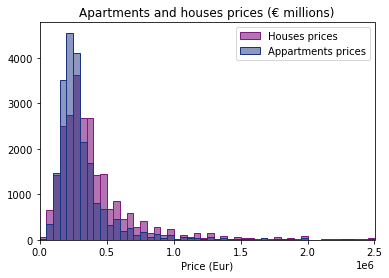

In [9]:
plt.hist(houses["Prix"],bins=range(0, 2500000 + 50000, 50000), color = (0.5,0.1,0.5,0.6),edgecolor = (0.5,0.1,0.5,1), label="Houses prices")
plt.hist(apartments["Prix"], bins=range(0, 2500000 + 50000, 50000), color=(0.1, 0.2, 0.5, 0.5),edgecolor = (0.1, 0.2, 0.5, 1), label="Appartments prices")
plt.xlim([0,2500000])
plt.title("Apartments and houses prices (€ millions)")
plt.xlabel("Price (Eur)")
plt.legend(loc='upper right')
plt.show()

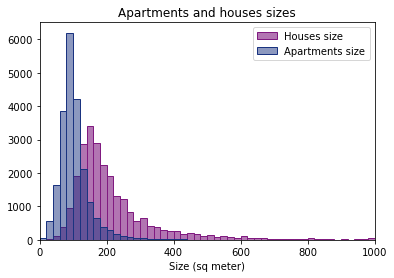

In [10]:
plt.hist(houses["Surface habitable"], bins=range(0, 1000 + 20, 20), color = (0.5,0.1,0.5,0.6),edgecolor = (0.5,0.1,0.5,1), label= "Houses size")
plt.hist(apartments["Surface habitable"], bins=range(0, 1000 + 20, 20), color=(0.1, 0.2, 0.5, 0.5),edgecolor = (0.1, 0.2, 0.5, 1), label= "Apartments size")
plt.xlim([0,1000])
plt.title("Apartments and houses sizes")
plt.xlabel("Size (sq meter)")
plt.legend(loc='upper right')
plt.show()

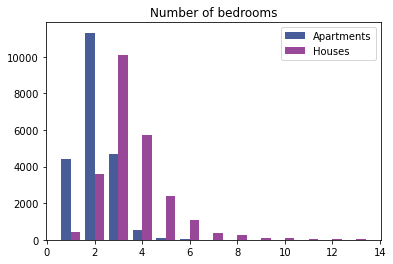

In [11]:
plt.hist([apartments["Chambres"], houses["Chambres"]], bins=(range(1,15)), align="left", label=['Apartments', 'Houses'], color=[(0.1, 0.2, 0.5, 0.8),(0.5,0.1,0.5,0.8)])
plt.title("Number of bedrooms")
plt.legend(loc='upper right')         
plt.show()

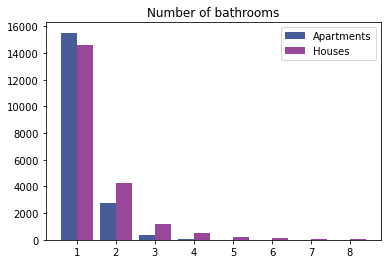

In [12]:
plt.hist([apartments["Salles de bains"], houses["Salles de bains"]], bins=(range(1,10)), align="left", label=['Apartments', 'Houses'], color=[(0.1, 0.2, 0.5, 0.8),(0.5,0.1,0.5,0.8)])
plt.title("Number of bathrooms")
plt.legend(loc='upper right')         
plt.show()

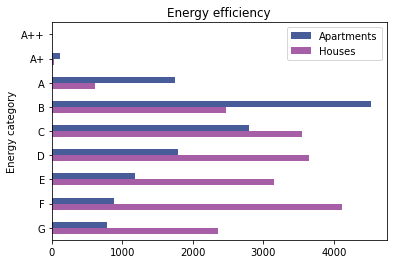

In [13]:
classe_ener_apart = apartments.groupby(['Classe énergétique']).count()
classe_ener_apart = pd.DataFrame({"Energy category":['A++','A+','A','B','C','D','E','F','G'],
                            "Apartments": classe_ener_apart["Identifiant"]})

classe_ener_houses = houses.groupby(['Classe énergétique']).count()
classe_ener_houses = pd.DataFrame({"Energy category":['A++','A+','A','B','C','D','E','F','G'],
                            "Houses": classe_ener_houses["Identifiant"]})

classe_ener = classe_ener_apart.merge(classe_ener_houses, on="Energy category")
classe_ener = classe_ener.set_index("Energy category")

classe_ener.plot.barh(title="Energy efficiency",
             color=[(0.1, 0.2, 0.5, 0.8),(0.5,0.1,0.5,0.7)])
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
plt.show()


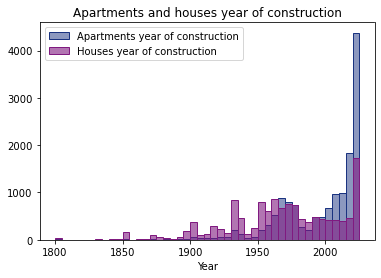

In [14]:
plt.hist(apartments["Année de construction"], bins=range(1800, 2025 + 5, 5), color=(0.1, 0.2, 0.5, 0.5),edgecolor = (0.1, 0.2, 0.5, 1), label= "Apartments year of construction")
plt.hist(houses["Année de construction"], bins=range(1800, 2025 + 5, 5), color = (0.5,0.1,0.5,0.6),edgecolor = (0.5,0.1,0.5,1), label= "Houses year of construction")
plt.title("Apartments and houses year of construction")
plt.xlabel("Year")
plt.legend(loc='upper left')
plt.show()

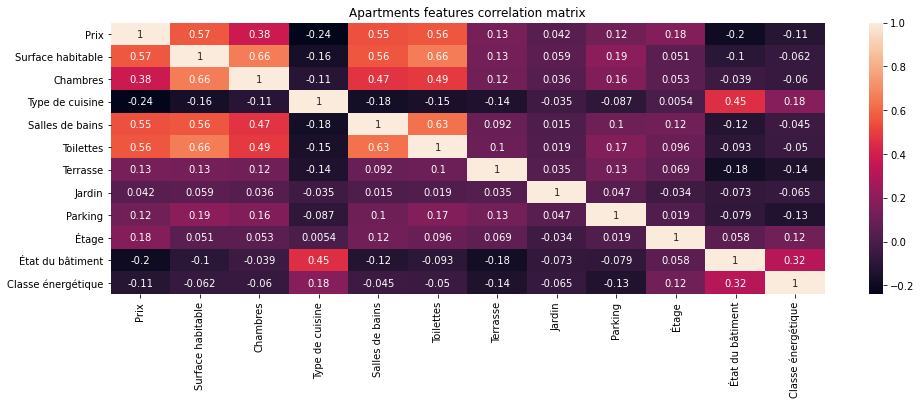

In [15]:
corr_analysis = apartments[["Prix",
                        "Surface habitable",
                        "Chambres",
                        "Type de cuisine",
                        "Salles de bains",
                        "Toilettes",
                        "Terrasse",
                        "Jardin",
                        "Parking",
                        "Étage",
                        "État du bâtiment",
                        "Classe énergétique"]]
plt.figure(figsize = (16,5))
sns.heatmap(corr_analysis.corr(), annot=True)
plt.title("Apartments features correlation matrix")
plt.show()

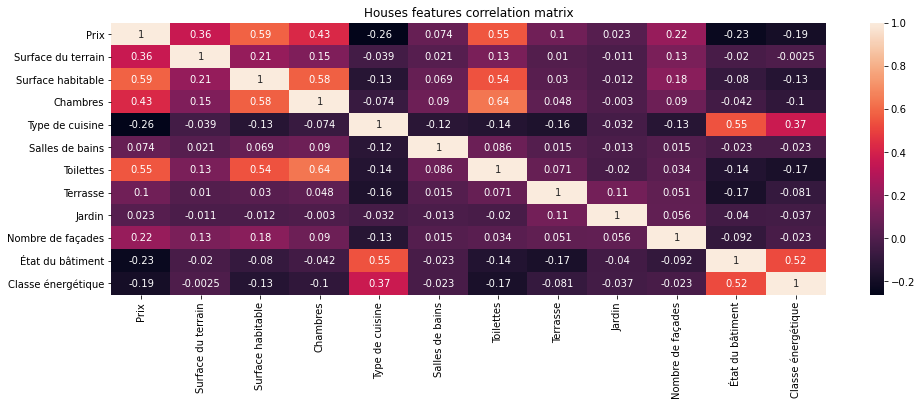

In [16]:
corr_analysis = houses[["Prix",
                      "Surface du terrain",
                      "Surface habitable",
                      "Chambres",
                      "Type de cuisine",
                      "Salles de bains",
                      "Toilettes",
                      "Terrasse",
                      "Jardin",
                      "Nombre de façades",
                      "État du bâtiment",
                      "Classe énergétique"]]
plt.figure(figsize = (16,5))
sns.heatmap(corr_analysis.corr(), annot=True)
plt.title("Houses features correlation matrix")
plt.show()

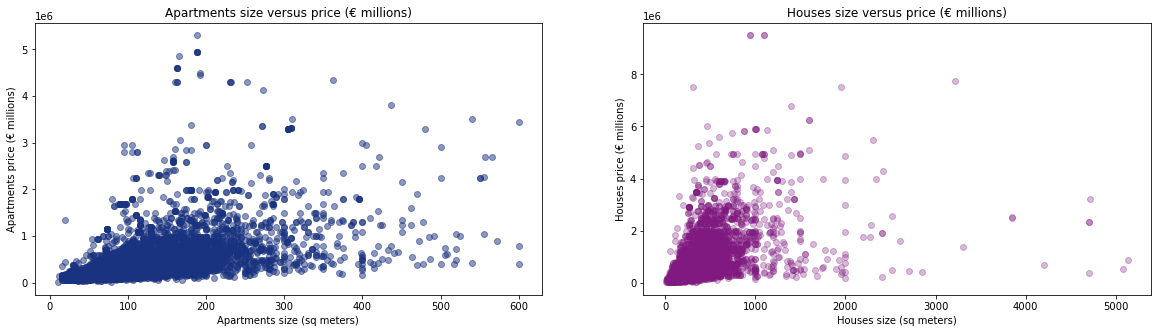

In [17]:
fig, axes = plt.subplots(1,2, figsize=(20,5))

axes[0].scatter(apartments["Surface habitable"],apartments["Prix"], color=(0.1, 0.2, 0.5, 0.5))
axes[0].set_title("Apartments size versus price (€ millions)")
axes[0].set_xlabel("Apartments size (sq meters)")
axes[0].set_ylabel("Apartments price (€ millions)")

axes[1].scatter(houses["Surface habitable"],houses["Prix"], color=(0.5,0.1,0.5,0.3))
axes[1].set_title("Houses size versus price (€ millions)")
axes[1].set_xlabel("Houses size (sq meters)")
axes[1].set_ylabel("Houses price (€ millions)")

plt.show()

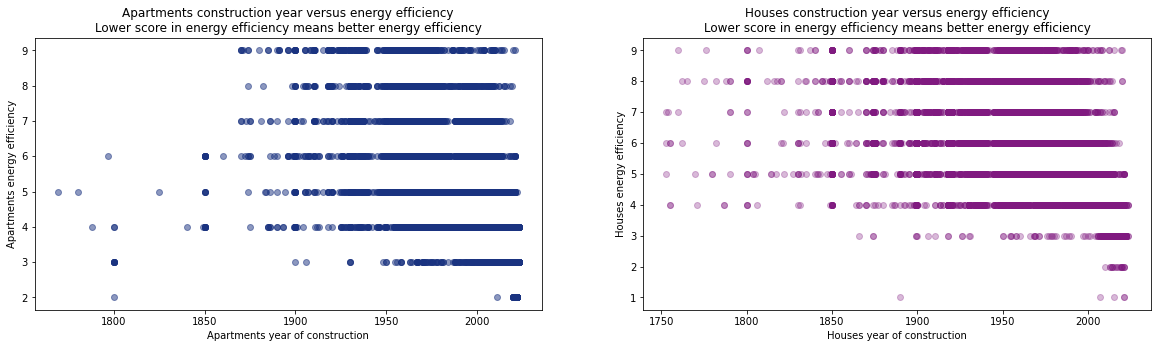

In [18]:
fig, axes = plt.subplots(1,2, figsize=(20,5))

axes[0].scatter(apartments["Année de construction"],apartments["Classe énergétique"], color=(0.1, 0.2, 0.5, 0.5))
axes[0].set_title("Apartments construction year versus energy efficiency\nLower score in energy efficiency means better energy efficiency")
axes[0].set_xlabel("Apartments year of construction")
axes[0].set_ylabel("Apartments energy efficiency")


axes[1].scatter(houses["Année de construction"],houses["Classe énergétique"], color=(0.5,0.1,0.5,0.3))
axes[1].set_title("Houses construction year versus energy efficiency\nLower score in energy efficiency means better energy efficiency")
axes[1].set_xlabel("Houses year of construction")
axes[1].set_ylabel("Houses energy efficiency")

plt.show()

## Apartments price analysis

In [19]:
# variables for the analysis of the price for apartments
apt_vars = apartments[["Prix",
                        "Surface habitable",
                        "Chambres",
                        "Type de cuisine",
                        "Salles de bains",
                        "Toilettes",
                        "Terrasse",
                        "Jardin",
                        "Parking",
                        "Étage",
                        "État du bâtiment",
                        "Classe énergétique",
                        "Revenu moyen",
                        "Pop densité (km2)",
                        "Degré d'urbanisation",
                        "Bxl",
                        "Knokke",
                        "Prix median 2020 appartements",
                        "Refnis"
                      ]]

### OLS / linear regression

In [20]:
# run OLS algorithm and show summary

algo = "OLS"
knokke_excl = False
df = apt_vars

x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
model, y_pred, r2 = OLS_regression(x_data, y_data)
model.summary()


<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     428.3
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:07:08   Log-Likelihood:                -59981.
No. Observations:                4399   AIC:                         1.200e+05
Df Residuals:                    4380   BIC:                         1.201e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -1.464e+05   3.19e+04     -4.581      0.000   -2.09e+05   -8.37e+04
Surface habitable              3307.2516    108.038     30.612      0.000    3095.442    3519.062
Chambres                      -4.366e+04   5408.088     -8.073      0.000   -5.43e+04   -3.31e+04
Type de cuisine               -1.182e+04   4659.651     -2.536      0.011    -2.1e+04   -2680.247
Salles de bains                8.933e+04   9072.995      9.846      0.000    7.15e+04    1.07e+05
Toilettes                       5.96e+04   7811.150      7.630      0.000    4.43e+04    7.49e+04
Terrasse                       1.115e+04   7455.129      1.496      0.135   -3461.311    2.58e+04
Jardin                         1.487e+04   1.44e+04      1.036      0.300   -1.33e+04     4.3e+04
Parking                        8708.3574   6629.207      1.314      0.189   -4288.241    2.17e+04
Étage                          7822.5476   1107.000      7.066      0.000    5652.268    9992.827
État du bâtiment              -2.378e+04   3068.511     -7.750      0.000   -2.98e+04   -1.78e+04
Classe énergétique            -1.126e+04   2295.837     -4.905      0.000   -1.58e+04   -6761.219
Revenu moyen                     -3.1815      1.166     -2.730      0.006      -5.466      -0.896
Pop densité (km2)                -0.7016      1.142     -0.615      0.539      -2.940       1.536
Degré d'urbanisation          -1.174e+04   9279.753     -1.265      0.206   -2.99e+04    6454.556
Bxl                           -2137.1151   1.31e+04     -0.163      0.870   -2.78e+04    2.35e+04
Knokke                         4.265e+05   2.75e+04     15.514      0.000    3.73e+05     4.8e+05
Prix median 2020 appartements     1.1772      0.104     11.293      0.000       0.973       1.382
Refnis                           -0.1958      0.202     -0.971      0.332      -0.591       0.200
==============================================================================
Omnibus:                     5050.409   Durbin-Watson:                   1.396
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           968704.365
Skew:                           5.694   Prob(JB):                         0.00
Kurtosis:                      74.801   Cond. No.                     2.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

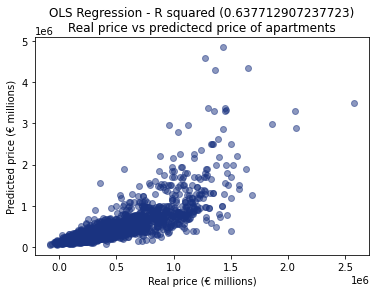

In [21]:
# plot predictions versus real price per square meter

plt.scatter(y_pred, y_data, color=(0.1, 0.2, 0.5, 0.5))
plt.title("OLS Regression - R squared ({})\nReal price vs predictecd price of apartments".format(r2))
plt.xlabel("Real price (€ millions)")
plt.ylabel("Predicted price (€ millions)")
plt.show()

### Random forest regression

In [22]:
# run random forest algorithm

algo = "RFR"
knokke_excl = False
df = apt_vars
x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
y_test_apt, y_pred_apt, r2_apt, model_RFR_apt = forest_regression(x_data, y_data) 

<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


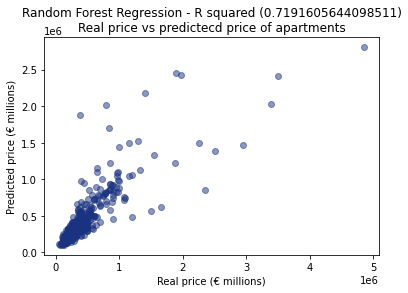

In [23]:
# plot predictions versus real price per square meter
plt.scatter(y_test_apt, y_pred_apt, color=(0.1, 0.2, 0.5, 0.5))
plt.title("Random Forest Regression - R squared ({})\nReal price vs predictecd price of apartments".format(r2_apt))
plt.xlabel("Real price (€ millions)")
plt.ylabel("Predicted price (€ millions)")
plt.show()

In [24]:
# list feature importances of the random forest predictions

features_importance_apt = model_RFR_apt.feature_importances_
print("Feature ranking:")
for i, data_class in enumerate(feature_names):
    print("{}. {} ({})".format(i + 1, data_class, features_importance_apt[i]))
print(sum(features_importance_apt))

Feature ranking:
1. Surface habitable (0.30922398408012974)
2. Chambres (0.022109790544077912)
3. Type de cuisine (0.010615949110544955)
4. Salles de bains (0.13496047768769015)
5. Toilettes (0.1724989882663917)
6. Terrasse (0.0019574081901230565)
7. Jardin (0.00757527347353992)
8. Parking (0.007707567922597736)
9. Étage (0.04825044524904134)
10. État du bâtiment (0.019229659047897987)
11. Classe énergétique (0.04191607543597482)
12. Revenu moyen (0.01706542576919007)
13. Pop densité (km2) (0.012585855559699774)
14. Degré d'urbanisation (0.002052149960334296)
15. Bxl (0.0017845051804917273)
16. Knokke (0.04262937467337526)
17. Prix median 2020 appartements (0.13140310241502218)
18. Refnis (0.016433967433877462)
1.0000000000000002


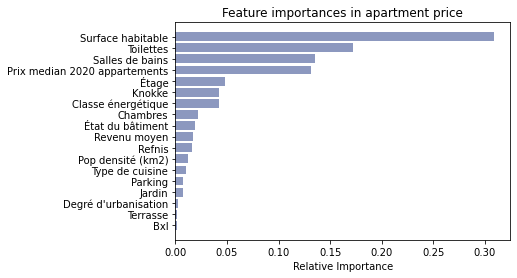

In [25]:
features = feature_names
importances = model_RFR_apt.feature_importances_
indices = np.argsort(importances)

plt.title('Feature importances in apartment price')
plt.barh(range(len(indices)), importances[indices],color=(0.1, 0.2, 0.5, 0.5), align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Houses price analysis

In [26]:
# variables for the analysis of the price for houses

houses_vars = houses[["Prix",
                      "Surface du terrain",
                      "Surface habitable",
                      "Chambres",
                      "Type de cuisine",
                      "Salles de bains",
                      "Toilettes",
                      "Terrasse",
                      "Jardin",
                      "Nombre de façades",
                      "État du bâtiment",
                      "Classe énergétique",
                      "Revenu moyen",
                      "Pop densité (km2)",
                      "Degré d'urbanisation",
                      "Bxl",
                      "Knokke",
                      "Prix median 2020 maisons",
                      "Refnis"
                     ]]

#### OLS / Linear regression

In [27]:
# run OLS algorithm and show summary

algo = "OLS"
knokke_excl = False
df = houses_vars
x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
model, y_pred, r2 = OLS_regression(x_data, y_data)
model.summary()

<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     1163.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:07:20   Log-Likelihood:            -1.0575e+05
No. Observations:                7617   AIC:                         2.115e+05
Df Residuals:                    7598   BIC:                         2.117e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1.129e+05   3.25e+04     -3.475      0.001   -1.77e+05   -4.92e+04
Surface du terrain          14.0837      0.320     44.065      0.000      13.457      14.710
Surface habitable         1157.6219     30.954     37.398      0.000    1096.944    1218.300
Chambres                 -1.525e+04   2851.165     -5.349      0.000   -2.08e+04   -9662.727
Type de cuisine          -1.462e+04   4485.508     -3.260      0.001   -2.34e+04   -5830.883
Salles de bains           8.875e+04   4915.958     18.053      0.000    7.91e+04    9.84e+04
Toilettes                 3.581e+04   4210.896      8.505      0.000    2.76e+04    4.41e+04
Terrasse                  7455.2396   6678.982      1.116      0.264   -5637.410    2.05e+04
Jardin                    4355.9145   6085.275      0.716      0.474   -7572.905    1.63e+04
Nombre de façades         6.141e+04   4011.249     15.309      0.000    5.35e+04    6.93e+04
État du bâtiment         -3.156e+04   3083.254    -10.236      0.000   -3.76e+04   -2.55e+04
Classe énergétique        -1.09e+04   2288.979     -4.762      0.000   -1.54e+04   -6412.325
Revenu moyen                -2.9785      1.172     -2.542      0.011      -5.276      -0.681
Pop densité (km2)          -11.9276      2.331     -5.117      0.000     -16.497      -7.359
Degré d'urbanisation     -5.682e+04   6392.788     -8.888      0.000   -6.94e+04   -4.43e+04
Bxl                       1.462e+05   2.46e+04      5.938      0.000     9.8e+04    1.95e+05
Knokke                    6.115e+05   4.22e+04     14.485      0.000    5.29e+05    6.94e+05
Prix median 2020 maisons     1.3420      0.065     20.529      0.000       1.214       1.470
Refnis                      -0.1113      0.172     -0.646      0.518      -0.449       0.226
==============================================================================
Omnibus:                     8321.067   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2334989.499
Skew:                           5.079   Prob(JB):                         0.00
Kurtosis:                      88.170   Cond. No.                     4.23e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

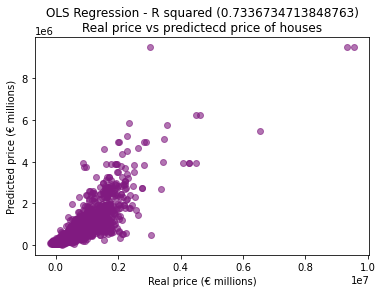

In [28]:
# plot predictions versus real price per square meter

plt.scatter(y_pred, y_data, color = (0.5,0.1,0.5,0.6))
plt.title("OLS Regression - R squared ({})\nReal price vs predictecd price of houses".format(r2))
plt.xlabel("Real price (€ millions)")
plt.ylabel("Predicted price (€ millions)")
plt.show()

 #### Random Forest Regression

In [29]:
# run random forest algorithm

algo = "RFR"
knokke_excl = False
df = houses_vars
x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
y_test, y_pred, r2, model_RFR_houses = forest_regression(x_data, y_data) 

<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


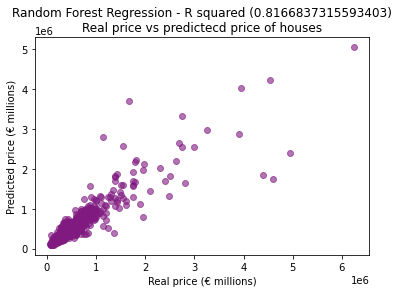

In [30]:
# plot predictions versus real price per square meter

plt.scatter(y_test, y_pred, color = (0.5,0.1,0.5,0.6))
plt.title("Random Forest Regression - R squared ({})\nReal price vs predictecd price of houses".format(r2))
plt.xlabel("Real price (€ millions)")
plt.ylabel("Predicted price (€ millions)")
plt.show()

In [31]:
# list feature importances of the random forest predictions

features_importance = model_RFR_houses.feature_importances_
print("Feature ranking:")
for i, data_class in enumerate(feature_names):
    print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))
print(sum(features_importance))

Feature ranking:
1. Surface du terrain (0.13050090528861139)
2. Surface habitable (0.44666265210891876)
3. Chambres (0.013010563193143853)
4. Type de cuisine (0.007476122972141409)
5. Salles de bains (0.03172135416421104)
6. Toilettes (0.02766767556162155)
7. Terrasse (0.0014183981146524743)
8. Jardin (0.0026948375893261056)
9. Nombre de façades (0.0033785049481428846)
10. État du bâtiment (0.015913543454621763)
11. Classe énergétique (0.01558679664412603)
12. Revenu moyen (0.012975803842474312)
13. Pop densité (km2) (0.025989464559396817)
14. Degré d'urbanisation (0.001965034325954135)
15. Bxl (0.0006933256877561866)
16. Knokke (0.004494174483362189)
17. Prix median 2020 maisons (0.2414249537327533)
18. Refnis (0.01642588932878591)
1.0


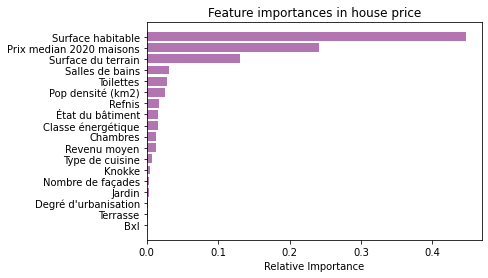

In [32]:
features = feature_names
importances = model_RFR_houses.feature_importances_
indices = np.argsort(importances)

plt.title('Feature importances in house price')
plt.barh(range(len(indices)), importances[indices], color = (0.5,0.1,0.5,0.6), align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## All properties listed (houses + apartments)

In [33]:
# variables for the analysis of the price for all properties

prop_vars = properties[["Prix",
                        "Surface habitable",
                        "Chambres",
                        "Type de cuisine",
                        "Salles de bains",
                        "Toilettes",
                        "Terrasse",
                        "Jardin",
                        "Parking",
                        "État du bâtiment",
                        "Classe énergétique",
                        "Revenu moyen",
                        "Pop densité (km2)",
                        "Degré d'urbanisation",
                        "Bxl",
                        "Knokke",
                        "Prix median 2020 appartements",
                        "Prix median 2020 maisons",
                        "Refnis"
                       ]]

### OLS regerssion

In [34]:
# run OLS algorithm and show summary

algo = "OLS"
knokke_excl = False
df = prop_vars
x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
model, y_pred, r2 = OLS_regression(x_data, y_data)
model.summary()

<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Prix   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     1096.
Date:                Tue, 30 Nov 2021   Prob (F-statistic):               0.00
Time:                        14:07:47   Log-Likelihood:            -1.6880e+05
No. Observations:               12097   AIC:                         3.376e+05
Df Residuals:                   12078   BIC:                         3.378e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -1.078e+05   2.69e+04     -4.009      0.000    -1.6e+05   -5.51e+04
Surface habitable              1431.9697     30.872     46.384      0.000    1371.456    1492.483
Chambres                      -1.413e+04   2740.549     -5.156      0.000   -1.95e+04   -8758.775
Type de cuisine               -2.466e+04   3860.632     -6.387      0.000   -3.22e+04   -1.71e+04
Salles de bains                9.874e+04   4859.483     20.318      0.000    8.92e+04    1.08e+05
Toilettes                      6.342e+04   4264.731     14.871      0.000    5.51e+04    7.18e+04
Terrasse                       1.235e+04   5687.622      2.172      0.030    1204.800    2.35e+04
Jardin                         1.501e+04   5815.304      2.581      0.010    3607.539    2.64e+04
Parking                        5.072e+04   5458.599      9.291      0.000       4e+04    6.14e+04
État du bâtiment              -2.783e+04   2557.298    -10.883      0.000   -3.28e+04   -2.28e+04
Classe énergétique            -7059.6173   1812.093     -3.896      0.000   -1.06e+04   -3507.623
Revenu moyen                     -0.4269      1.031     -0.414      0.679      -2.448       1.594
Pop densité (km2)                -4.8619      1.221     -3.983      0.000      -7.255      -2.469
Degré d'urbanisation           -3.81e+04   7017.535     -5.429      0.000   -5.19e+04   -2.43e+04
Bxl                           -1.458e+04   1.43e+04     -1.021      0.307   -4.25e+04    1.34e+04
Knokke                         4.186e+05   2.55e+04     16.441      0.000    3.69e+05    4.68e+05
Prix median 2020 appartements     0.1213      0.118      1.027      0.304      -0.110       0.353
Prix median 2020 maisons          0.8615      0.058     14.854      0.000       0.748       0.975
Refnis                           -0.2238      0.153     -1.464      0.143      -0.523       0.076
==============================================================================
Omnibus:                    14395.063   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7891414.894
Skew:                           5.741   Prob(JB):                         0.00
Kurtosis:                     127.597   Cond. No.                     4.43e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

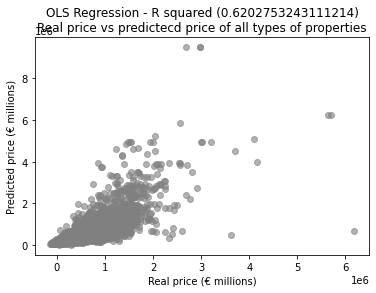

In [35]:
# plot predictions versus real price per square meter

plt.scatter(y_pred, y_data, color = (0.5,0.5,0.5,0.6))
plt.title("OLS Regression - R squared ({})\nReal price vs predictecd price of all types of properties".format(r2))
plt.xlabel("Real price (€ millions)")
plt.ylabel("Predicted price (€ millions)")
plt.show()

### Random Forest Regression

In [ ]:
# run random forest algorithm
algo = "RFR"
knokke_excl = False
df = prop_vars
x_data, y_data, feature_names = load_data(df, algo, knokke_excl)
y_test, y_pred, r2, model_RFR_all = forest_regression(x_data, y_data) 

<ipython-input-6-e22f4f556d46>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


In [ ]:
# plot predictions versus real price per square meter

plt.scatter(y_test, y_pred, color = (0.5,0.5,0.5,0.6))
plt.title("Random Forest Regression - R squared ({})\nReal price vs predictecd price of all property types".format(r2))
plt.xlabel("Real price (€ millions)")
plt.ylabel("Predicted price (€ millions)")
plt.show()

In [ ]:
# list feature importances of the random forest predictions

features_importance = model_RFR_all.feature_importances_
print("Feature ranking:")
for i, data_class in enumerate(feature_names):
    print("{}. {} ({})".format(i + 1, data_class, features_importance[i]))
print(sum(features_importance))

In [ ]:
features = feature_names
importances = model_RFR_all.feature_importances_
indices = np.argsort(importances)

plt.title('Feature importances in property price')
plt.barh(range(len(indices)), importances[indices], color = (0.5,0.5,0.5,0.6), align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()